<a href="https://colab.research.google.com/github/kylehounslow/bmw_2019/blob/master/notebooks/object_measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Object Detection and 3D measurement from point cloud  
___
Topics covered in this notebook:  
* Importing code from Github to work with Colab  
* Object detection with YOLOv3  
* Working with Depth images  
* Combining object detection and point cloud data to localize objects in 3D space.

## Environment setup

### Make sure our runtime has a GPU attached usig `nvidia-smi` shell command

In [0]:
!nvidia-smi

### clone the `bmw_2019` repository to our colab instance and install the required libraries

---



In [39]:
!rm -rf bmw_2019 && git clone --quiet https://github.com/kylehounslow/bmw_2019.git
!pip install --quiet -r bmw_2019/requirements_colab.txt

     |████████████████████████████████| 3.7MB 4.9MB/s 


### Import the YOLOV3 module and some other dependencies

In [0]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import youtube_dl
from google.colab.files import download
from bmw_2019.models.keras_yolov3 import YOLOV3
from bmw_2019 import util
plt.style.use('default')
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Object Detection

### Instatiate the detector  
The `__init__` function for `YOLOV3` will take care of downloading the pretrained model weights and setting up the necessary variables for inference.  
See code [here](https://github.com/kylehounslow/bmw_2019/blob/master/models/keras_yolov3/src/yolo.py)

In [0]:
detector = YOLOV3()

### Render the YOLOV3 Model Architecture a notebook cell
Note: You'll need to zoom in!

In [0]:
import numpy as np
import tensorflow as tf
from IPython.display import  HTML
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
show_graph(tf.get_default_graph())

### Download image from URL and run detection
 The following defines a form widget for user input, downloads image and runs inference 

In [0]:
#@title ## Detect objects from image url
#@markdown ### Enter an image URL:
url = "https://i.ytimg.com/vi/gcI1BP1SlCk/maxresdefault.jpg" #@param {type:"string"}
img = util.download_image(url)
plt.figure(figsize=(18,12))
plt.title("Original Image")
plt.imshow(img)
plt.show()
detections = detector.detect(image=img)
img_draw = detector.draw_detections(img, detections)
plt.figure(figsize=(18,12))
plt.title("Detections")
plt.imshow(img_draw)

### Or we can capture image from client webcam

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture and Detect';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

try:
    filename = take_photo()
    img = Image.open(filename)
    img = np.array(img)
    detections = detector.detect(image=cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img_draw = detector.draw_detections(img, detections)
    plt.figure(figsize=(18,12))
    plt.imshow(img_draw)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
    print(str(err))

### Or we can upload an image and run detection 

In [0]:
from PIL import Image
import cv2
from google.colab import files
def upload_detect_show(detector):
    uploaded_files = files.upload()
    image_filenames = list(uploaded_files.keys())
    for image_filename in image_filenames:
        image = Image.open(image_filename)
        detections = detector.detect(image=image)
        img_draw = detector.draw_detections(image, detections)
        return Image.fromarray(img_draw)
upload_detect_show(detector=detector)

## Working with Depth data

### Load RGBD image

In [31]:
rgbd = cv2.imread('./bmw_2019/notebooks/data/rgbd1.png', cv2.IMREAD_UNCHANGED)  # NOTE: IMREAD_UNCHANGED loads image as its original uint16 dtype
print(rgbd.shape, rgbd.dtype)

(720, 1280, 4) uint16


### Split the RGBD image into RGB + Depth
Recall that numpy images are indexed by `[row, col, channel]`

In [32]:
rgb = rgbd[:, :, :3]  # first 3 channels is RGB
depth = rgbd[:, :, -1]  # last channel is depth

print(rgb.shape, rgb.dtype, depth.shape, rgb.dtype)

(720, 1280, 3) uint16 (720, 1280) uint16


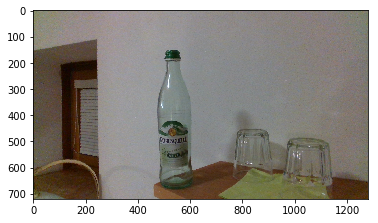

In [33]:
plt.imshow(rgb)

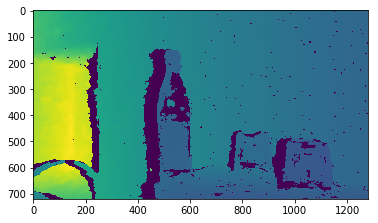

In [34]:
plt.imshow(depth)

### Load Pointcloud data

In [38]:
pc = np.load('./bmw_2019/notebooks/data/pc1.npy')
print(pc.shape, pc.dtype)

(720, 1280, 3) float32


### Visualize point cloud with `open3d`

In [48]:
%matplotlib --list

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'inline', 'ipympl', 'widget']


In [0]:
import open3d as o3d
from open3d import JVisualizer
o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Debug)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pc.reshape(-1, 3))  # NOTE: we need to flatten row, col dimensions
o3d.io.write_point_cloud('pc.ply', pcd)
pcd_load = o3d.io.read_point_cloud('pc.ply')
visualizer = JVisualizer()
visualizer.add_geometry(pcd_load)
visualizer.show()

In [59]:
pc.shape

(720, 1280, 3)

In [60]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax3d = Axes3D(fig)
ax3d.scatter(xs=pc[:,:, 0],ys=pc[:,:,1], zs=pc[:,:,2])
plt.show()

KeyboardInterrupt: ignored